Notebook adaptado del curso “Diplomatura en Inteligencia Artificial y Ciencia de Datos” dictado por la ECyT-UNSAM en el marco del plan Argentina Programa 4.0

# Clasificación

## Repaso de regresión

Hasta ahora estuvimos viendo problemas de **regresión**, donde la variable *target* ($t$; por ejemplo, el precio de las casas en el dataset de Properati) es una varible continua y vimos cómo abordar los problemas de regresión utilizando **modelos lineales**, es decir, aquellos donde la respuesta de la variable target es lineal con el cambio de las *características* de los datos. Por ejemplo, si aumenta la superficie de un vivienda en un metro cuadrado, el modelo predice el **mismo aumento en el precio**, independientemente de si pasamos de un monoambiente de 18 $\text{m}^2$ a 19 $\text{m}^2$ o si pasamos de una cinco ambientes de 180 $\text{m}^2$ a 181 $\text{m}^2$.

¿Poco realista? Puede ser, pero recuerden que esta idea sencilla es mucho más flexible de lo que parece, porque podemos incluir **características no lineales**, como "superficie al cuadrado", que nos permiten captar relaciones más complejas conservando toda la simpleza matemática de los modelos lineales (❤️).

## Un mundo nuevo: clasificación

En los problemas de **clasificación** la variable a modelar es una *categoría* o *clase*.

Ejemplos:

1. Si la propiedad es una casa o un departamento (Properati)
2. El tipo de corte de un diamante (diamonds)
3. La cercanía al océano de un distrito (California)
...

En estos casos, también vamos a poder usar **modelos lineales** pero vamos a tener que darles una vuelta de rosca para convertirlos en **modelos lineales generalizados**.

Al igual que venimos haciendo, el objetivo va a ser modelar la variable *target* en función de una serie de *características* (que llamaremos en general $X$, pero vamos a intentar ser más explícitos en este notebook).

Además, las tareas de clasificación pueden subdividirse según el número de objetivos que tengamos (etiqueta única o etiqueta múltiple) y el número de valores, o *clases*, que puede tomar el objetivo (binario o multiclase), pero estos son temas más avanzados. Arranquemos desde el principio.

### Un detalle: codificar las clases

¿Cómo hacemos para que un algoritmo entienda que tiene que separar los datos que son "departamentos" de "casas"? En principio, necesitamos **codificar** estas clases para poder operar con ellas.

Se puede codificar variables explicativas (**características**) categóricas usando, por ejemplo, `OneHotEncoder`, de sklearn, esto asignará un número a cada categoría existente. Acá vamos a hacer algo parecido. Una práctica común, en los casos binarios que vamos a estudiar hoy (es decir, donde solo hay dos clases, que además son excluyentes), es que la variable target tome valores 0 (o -1) y 1 dependiendo de si la instancia es una casa o un depto, respectivamente. Por supuesto, hay arbitrariedad en cuál es la clase 0 y la clase 1; en general, se elijen según las características del problema.

El ejemplo que veremos ya está codificado, si por ejemplo se quiere crear una nueva columna codificada con `tipo_propiedad` del dataset de properati se puede utilizar `LabelEncoder`:

***
```python
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_properati['tipo_propiedad_encoded'] = label_encoder.fit_transform(df_properati['tipo_propiedad'])
...




## Clasificación binaria

[Old Faithful](https://es.wikipedia.org/wiki/Old_Faithful) es un geiser del parque Yellowstone que exhibe una notable regularidad entre erupciones. Las erupciones pueden largar entre 14,000 y 32,000 litros de agua hirviendo a una altura de más de 50 metros.

La duración de las erupciones muestra una distribución bimodal, es decir, que hay erupciones "largas" y "cortas". Veamos los datos de duración en relación con el intervalo entre erupciones (tiempo de espera de cada erupción).

**Invento**. Vamos a suponer que las erupciones de Old Faithful pueden separarse en dos clases, según el grado de salinidad de las erupciones. Para eso, hay que extraer una muestra del agua de una erupción, y medir su salinidad con alguna técnica de laboratorio.

Preparamos un dataset de duración y tiempo espera entre las erupciones, y agregamos una variable según si la erupción fue clasificada como de "alta salinidad" (clase 1) o "baja salinidad" (clase 0).

In [1]:
import os
import pandas as pd
from google.colab import drive

drive.mount("/content/drive")
df = pd.read_csv('https://raw.githubusercontent.com/nicklessagus/AA_Nuclear/refs/heads/main/Data/faithful1.csv')

# Veamos las primeras líneas
df.info()

df.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   durac_erup  272 non-null    float64
 1   espera      272 non-null    int64  
 2   clase       272 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 6.5 KB


,durac_erup,espera,clase
0,3.600,79,1
1,1.800,54,0
2,3.333,74,1
3,2.283,62,0
4,4.533,85,1


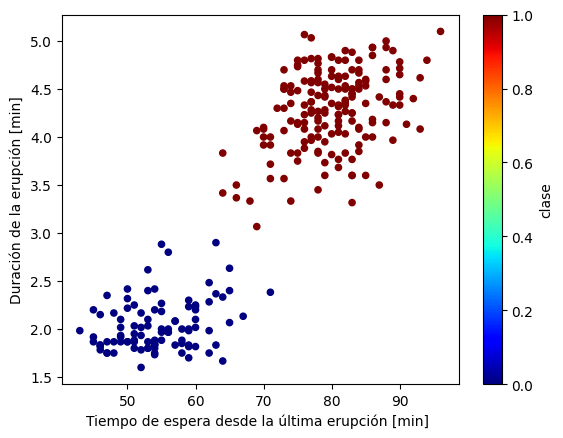

In [2]:
import matplotlib.pyplot as plt

# Plot del dataset
# forzamos a que los datos de 'clase' sean del tipo categórica, sino nos hace el degradé de colores
df.loc[:, 'clase'] = pd.Categorical(df.clase)

def plot_data():
    _ = df.plot.scatter(x='espera', y='durac_erup', c='clase',
                        xlabel='Tiempo de espera desde la última erupción [min] ',
                        ylabel='Duración de la erupción [min]',
                        cmap='jet')
    return

plot_data()


In [3]:
df.clase.value_counts()

,count
clase,
1,175
0,97


Vemos fácilmente que las erupciones de salinidad diferente se separan en este plano.
Podemos entonces pensar en un modelo que a partir del tiempo de espera y la duración de la erupción **clasifique** a los eventos de Old Faithful y evitarnos tener que medir la salinidad.

¿Cómo lo hacemos?

1. Gráficamente.

2. Con una receta escrita explícitamente.

Buscamos los valores concretos de la pendiente ($m$) y la ordenada al origen ($b$):

$$\text{duración} = m \times \text{tiempo de espera} + b$$

3. Con un método automático.

Para esto, conviene expresar la recta de arriba como

$$\omega_0 + \omega_1 \times \text{tiempo de espera} + \omega_2 \times \text{duración} = 0$$

Entonces, la **frontera de decisión** es el lugar del espacio de los datos en el que la **función de decisión**

$$
y(\text{datos}, \boldsymbol{\omega}) = \omega_0 + \omega_1 \times \text{tiempo de espera} + \omega_2 \times \text{duración}$$

vale 0.


Así, cada punto tiene un valor de $y$. Hay dos propiedades de la función de decisión que son importantes:

1. de un lado de la frontera los valores de la función de decisión $y$, son positivos y del otro son negativos.
2. cuanto más lejos está un punto de la frontera de decisión, mayor es el valor absoluto de $y$.

Entonces, para armar un algoritmo que clasifica las instancias de un set de datos, podemos aplicar una **función escalón** a la **función de decisión**.

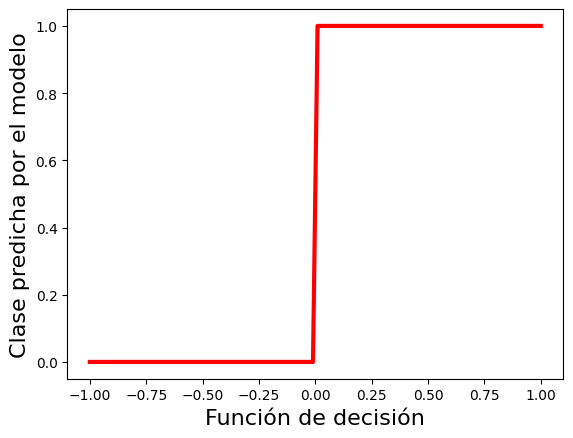

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Vector para el gráfico
x = np.linspace(-1, 1, 100)

# Función escalón, también conocida como theta de Heaviside
# ver https://es.wikipedia.org/wiki/Funci%C3%B3n_escal%C3%B3n_de_Heaviside
y = np.heaviside(x, 0.5)

plt.plot(x, y, lw=3, color='r')
plt.xlabel('Función de decisión', size=16)
plt.ylabel('Clase predicha por el modelo', size=16)
plt.show()


En pocas palabras, el método es:

1. Encontrar la mejor frontera de decisión (ver más abajo cómo hacer esto) con el conjunto de entrenamiento.
2. Con los parámetros ajustados, calcular el valor de $y$ para un datapoint que se quiera clasificar.
3. Si $y > 0$, clasificar como clase 1; de lo contrario, clasificar como clase 0.

## Perceptrón


La pregunta que sigue es: ¿cómo hacemos para encontrar de forma automática los valores de los parámetros $\omega0$, $\omega1$ y $\omega2$ que crean la mejor frontera de decisión?

Esta pregunta está asociada a la elección de una **función de error**. ¿Qué creen que pasaría si eligiéramos como función de error al MSE o MAE?

### La función de error

Los problemas de clasificación tienen funciones de error propias.
Cuando usamos una función escalón como describimos arriba, lo más común es usar la **función de error del perceptrón**, que básicamente es igual a la suma de las distancias a la frontera de decisión de los puntos mal clasificados (conjunto que llamamos $\mathcal{M}$).

$$
E_p = \sum_{i \in \mathcal{M}} |y(\text{datos}_i, \boldsymbol{\omega})|\;\;.
$$

El módulo es complicado si uno quiere derivar e igualar a cero para encontrar el mínimo de esta función, pero hay formas astutas de escribir lo mismo, sin usar el módulo.

### Implementación en `scikit-learn`

In [5]:
from sklearn.linear_model import Perceptron

# Instancio un perceptrón con los parámetros por defecto
perce = Perceptron()

In [6]:
# Preparo la data en formato que entienda el bicho

# Separo el target
clase = df.clase.to_numpy()

# Tiro el target de la data
datos = df.drop(['clase'], axis=1, inplace=False)
# Reordeno los datos
datos = datos[['espera', 'durac_erup']]

# Los normalizo, porque los valores son grandes
from sklearn.preprocessing import StandardScaler
stsc = StandardScaler()
datosn = stsc.fit_transform(datos) #fit_transform: Calcula la media y desviación estándar de los datos (fit)
#y luego aplica la transformación (transform) a los datos originales.

# Chequeo
# datosn.columns

In [8]:
# Ajusto el perceptron
perce.fit(datosn, clase)

Perceptron()

Al igual que con los otros algoritmos, podemos ver los coeficientes y el "intercept"

In [9]:
print('Omega_0 = {:.2f}'.format(*perce.intercept_))
print('Omega_1 = {:.2f}'.format(perce.coef_[0][0]))
print('Omega_2 = {:.2f}'.format(perce.coef_[0][1]))

Omega_0 = 1.00
Omega_1 = 1.19
Omega_2 = 1.44


### Funciones útiles

Definamos algunas funciones útiles para graficar fronteras de decisión en dos dimensiones y para obtener el vector de los pesos del modelo lineal.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#Dibuja un gráfico con los datos de clasificación (dos clases) y las rectas de decisión de uno o varios modelos lineales.
def plot_clasi(x, t, ws, labels=[], xp=[-1,1], spines='zero',
               equal=True, join_centers=False, margin=None, **kwargs):
    """
   Trazar los resultados de problemas de clasificación lineal.
    :x: matriz de datos
    :t: Vector de etiqueta.
    :list o tuple ws: lista con vector de parámetros ajustado de modelos, un elemento por modelo
    :tuple xp: coordenadas x iniciales y finales de los límites de decisión y márgenes.
    :str o Ninguna spines: si los spines pasan por cero. Si ninguno, se utiliza el comportamiento predeterminado.
    :param bool: si se debe utilizar el aspecto del eje predeterminado = Verdadero
    :param bool join_centers: si se deben dibujar líneas entre los centros de clases.
    :param None o margen de tupla: tupla de valores booleanos que definen si para trazar el margen para cada modelo que se está trazando.
    Si no hay ninguno, Falso para todos los modelos.
    """
    assert len(labels) == len(ws) or len(labels) == 0

    if margin is None:
        margin = [False] * len(ws)
    else:
        margin = np.atleast_1d(margin)
    assert len(margin) == len(ws)

    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')

    # Agregemos el vector al plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111)

    xc1 = x[t == np.unique(t).max()]
    xc2 = x[t == np.unique(t).min()]

    ax.plot(*xc1.T, 'or', mfc='None', label='C1')
    ax.plot(*xc2.T, 'ob', mfc='None', label='C2')

    for i, w in enumerate(ws):
        # Separa el sesgo del resto de los pesos
        thr = -w[0]
        w = w[1:]
        # Calcula la norma del vector
        wnorm = np.sqrt(np.sum(w**2))

        # Ploteo vector de pesos
        ax.quiver(0, thr/w[1], w[0]/wnorm, w[1]/wnorm,
                  color='C{}'.format(i+2), scale=10, label=labels[i],
                  zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr - w[0]*xp)/w[1]

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))

        '''# ploteo el margen (para SVC)
        if margin[i]:
            for marg in [-1, 1]:
                ym = yp + marg/w[1]
                plt.plot(xp, ym, ':', color='C{}'.format(i+2))'''

    '''if join_centers:
        # Ploteo línea que une centros de los conjuntos
        mu1 = xc1.mean(axis=1)
        mu2 = xc2.mean(axis=1)
        ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)'''

    ax.legend(loc=0, fontsize=12)
    if equal:
        ax.set_aspect('equal')

    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)

    for k in kwargs:
        print(k, kwargs[k])
        getattr(ax, 'set_'+k)(kwargs[k])

    return

#Extrae y prepara los parámetros (w y bias) de un modelo.
def makew(fitter, norm=False):
    """
    Se prepara el vector de parámetros para un predictor sklearn.liner_model.
    :param sklearn.LinearModel ajustador: el modelo utilizado para clasificar los datos
    :param bool norma: predeterminado: Falso; si se debe normalizar el vector de parámetros
    """
    # # Obtengamos los pesos
    w = fitter.coef_.copy()

    # # Agrega el termino independiente (bias o intercept)
    if fitter.fit_intercept:
        w = np.hstack([fitter.intercept_.reshape(1, 1), w])

    # # Normalizo el vector completo si se pide
    if norm:
        w /= np.linalg.norm(w)
    return w.T         #devuelve la transpuesta para que quede de la forma [bias, w1, w2]

#Grafica la función de decisión de un modelo sobre una cuadrícula de puntos:
def plot_fundec(fitter, x, t):
    from matplotlib import colors

    plt.figure(figsize=(9, 7))
    #Crea una malla de coordenadas donde se evaluará la función de decisión:
    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200),
                            np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evalúa la salida del modelo (distancia al hiperplano) para cada punto de la grilla.
    Z = fitter.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # veamos la función de decisión y la frontera de decisión. Dibuja mapa de colores, Colorea las zonas según el valor de la función de decisión:
    mynorm = colors.TwoSlopeNorm(vmin=Z.min(), vmax=Z.max(), vcenter=0.0)
    pme = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu_r, norm=mynorm, shading='auto')
    plt.colorbar(label='Función de decisión')
    plt.contour(xx, yy, -Z, 0, colors='0.5', zorder=1) #representa la forntera de decision
    # plt.contour(xx, yy, -Z, [-1, 1], colors='0.25', linestyles='dashed', zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    plt.plot(*xc1.T, 'or', mfc='None', label='C1')
    plt.plot(*xc2.T, 'ob', mfc='None', label='C2')

    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

    return pme


[[1.        ]
 [1.18666092]
 [1.44497368]]
xlabel Tiempo de espera [normalizado]
ylabel Duración de la erupción [normalizado]


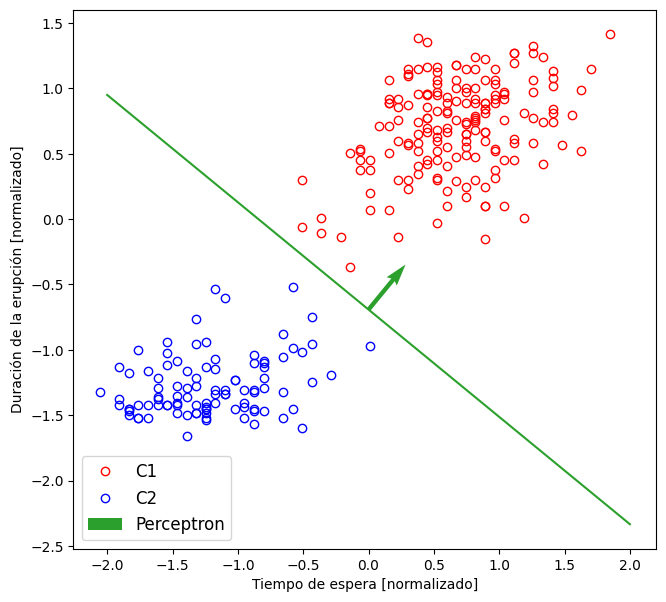

In [11]:
# Creo el vector de pesos para representar los parámetros ajustados del modelo de clasificación
w_perce = makew(perce)
print(w_perce)
plot_clasi(datosn, t=clase, ws=[w_perce,], xp=[-2, 2], labels=['Perceptron', ],
           spines=None,
           xlabel='Tiempo de espera [normalizado]',
           ylabel='Duración de la erupción [normalizado]')
#spines controla la posición de los ejes. Establecerlo en None hace que los ejes queden en sus posiciones estándar,
#mientras que establecerlo en 'zero' alinea los ejes con el origen (0,0).

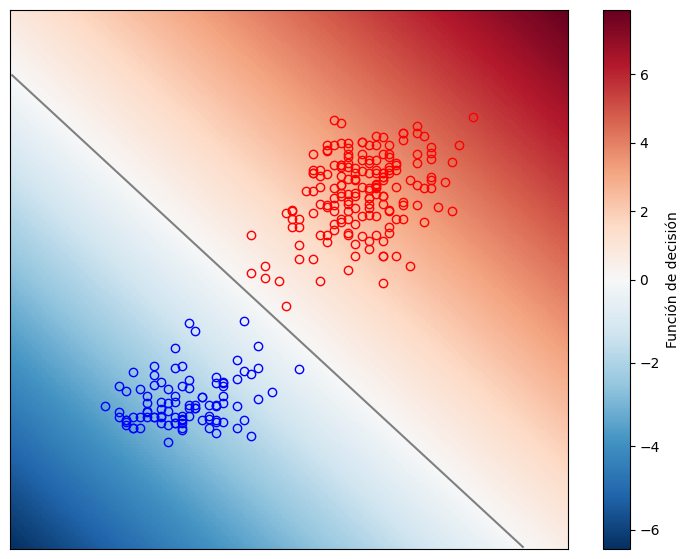

In [12]:
plot_fundec(perce, datosn, clase)

Al perceptron también se le puede pedir que prediga a qué clase pertenece cada instancia, se muestran dos formas de código para que nos muestre.

In [15]:
# predicciones del perceptron
preds = perce.predict(datosn) #Esto devuelve directamente las clases

In [18]:
#Como sabemos que el umbral es 0: Si la función de decisión ≥ 0 → clase 1 y Si < 0 → clase 0:
preds2 = np.where(perce.decision_function(datosn) >= 0, 1, 0) #perce.decision_function(X): no da las clases,
#si no los valores continuos de la función de decisión del perceptrón para cada muestra(las distancias al plano de separación)
np.allclose(preds, preds2)
#preds2 contiene las mismas clases que perce.predict(X)

True

### Dependencia con las condiciones iniciales

Una característica del algoritmo planteado más arriba es que podemos converger a distintas soluciones, según el punto inicial del que partamos.

El punto inicial puede elegirse de forma aleatoria o podemos fijarlo usando los argumentos `coef_init` e `intercept_init` del método `fit`:

In [17]:
# Definimos un punto inicial, vector inicial de pesos: w0
w0 = np.array([5.0, 5.0]).reshape(1, 2) #crea un vector con los valores [5.0, 5.0], y reshape(1, 2) lo convierte en una matriz de 1x2.
intercept = np.array([-2,]) #bias con valor -2

# Ajustamos arrancando en la posición, w=[5.0, 5.0], b=-2.
perce.fit(datosn, clase, coef_init=w0, intercept_init=intercept) #almacena el vector de pesos del modelo Perceptron ajustado.
w_perce2 = makew(perce) #La función makew(perce) se utiliza aquí para extraer el vector de pesos después del entrenamiento.
print(w_perce2)

[[3.        ]
 [4.00623922]
 [4.19078492]]


Y podemos graficar ambas soluciones:

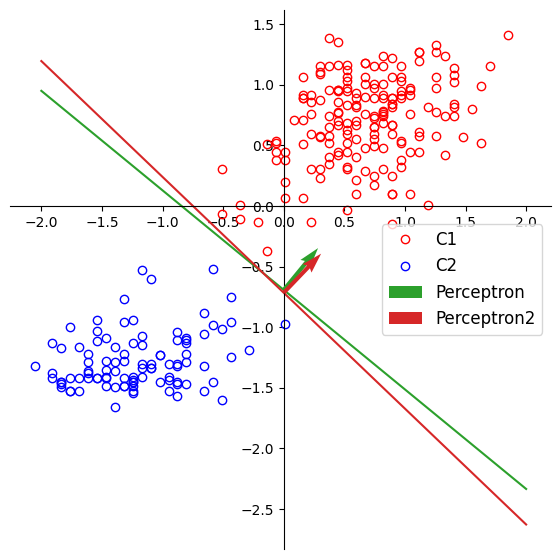

In [ ]:
plot_clasi(datosn, clase, [w_perce, w_perce2], ['Perceptron', 'Perceptron2'], xp=[-2, 2])

O podemos ver soluciones múltiples

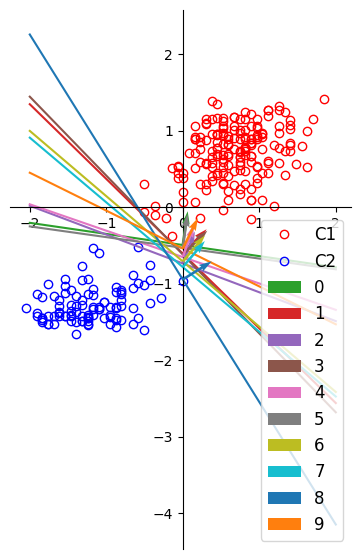

In [19]:
w0s = np.random.rand(10, 2) * 5.0
intercepts = np.random.rand(10) * 5.0

wlist = []
thlist = []
for i in range(len(w0s)):
    perce.fit(datosn, clase, coef_init=w0s[i], intercept_init=intercepts[i])
    w_p = makew(perce)
    wlist.append(w_p)

plot_clasi(datosn, clase, wlist, xp=[-2, 2])

In [20]:
#ACÁ VA UN EJERCICIO CON MAKEMOONS USANDO POLINOMIAL FEATURES

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

perce_cuad = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('perce', Perceptron(fit_intercept=False))
])

In [ ]:
perce_cuad.fit(datosn, clase)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('perce', Perceptron(fit_intercept=False))])

## Métricas

Para decidir cuán bien funciona nuestro clasificador, necesitamos definir alguna métrica. Las siguientes son opciones comunes:

* Exactitud (accuracy): ¿Qué fracción de los puntos están clasificados correctamente?
* Precisión: ¿Cuántos puntos de los que predecimos que pertenecen a la Clase 1, realmente son de esa clase? Por supuesto, podemos también definir la precisión para la Clase 2 de manera análoga.
* Exhaustividad (recall): ¿Qué fracción de los puntos de la Clase 1 son clasificados como Clase 1?

Dependiendo de qué nos interese más, y cuán balanceado esté nuestro dataset (balance entre una clase y otra) eligiremos una u otra métrica. En el caso en el que estamos interesados en la precisión **Y** la exhaustividad, podemos considerar la media armónica de ambas:

* score F1: media armónica de la precisión y la exhaustividad.

Esta forma de calcular la media le da más peso al menor valor, de manera que un score F1 alto significa que tanto la precisión como la exhaustividad son altas.

Todas estas métricas se pueden calcular a partir de la *matriz de confusión*:

|  | Predicción C2 (-) | Predicción C1 (+) |
| --- | --- | --- |
| **Etiqueta C2 (-)** | Verdaderos Negativos (VN)  | Falsos Positivos (FP) |
| **Etiqueta C1 (+)** | Falsos Negativos (FN) | Verdaderos Positvos (VP) |

$$\text{Exactitud} = \frac{VP + VN}{VP+VN+FP+FN}$$
$$\text{Precisión} = \frac{VP}{VP+FP}$$
$$\text{Exhaustividad} = \frac{VP}{VP+FN}$$

Por supuesto, todo esto está implementado en `sklearn`, en el paquete `metrics`.

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print(f"Exactitud: {round(accuracy_score(clase, preds), 2)}")
print(f"Precisión: {round(precision_score(clase, preds), 2)}")
print(f"Exhaustividad: {round(recall_score(clase, preds), 2)}")
print("Matriz de confusión:")
print(confusion_matrix(clase, clase))

Exactitud: 1.0
Precisión: 1.0
Exhaustividad: 1.0
Matriz de confusión:
[[ 97   0]
 [  0 175]]


Como es de esperar viendo los gráficos de arriba, en estos casos el funcionamiento del algoritmo es perfecto.

## Linealmente separable. ¿Qué significa?

Empecemos con un dataset bastante particular. Lo generamos con la celda a continuación y lo graficamos después.

In [22]:
def make_circle_data():

    np.random.seed(2022)

    x = np.random.multivariate_normal(mean=[0,0], cov=[[1, 0],[0, 1]], size=1000).T
    r = (x[0]**2 + x[1]**2)

    xc1 = x[:, r < 0.9]
    xc2 = x[:, r > 1.1]

    # Uso coordenadas polares
    rc1 = np.sqrt(xc1[0]**2 + xc1[1]**2)
    thetac1 = np.arctan2(xc1[1], xc1[0])
    rc2 = np.sqrt(xc2[0]**2 + xc2[1]**2)
    thetac2 = np.arctan2(xc2[1], xc2[0])

    phi1 = np.vstack([rc1[np.newaxis, :], thetac1[np.newaxis, :]])
    phi2 = np.vstack([rc2[np.newaxis, :], thetac2[np.newaxis, :]])

#     phi1 = rc1[np.newaxis, :]
#     phi2 = rc2[np.newaxis, :]

    # Creamos la matrix de diseño completa y los labels
    t1 = np.ones_like(rc1)
    t2 = np.zeros_like(rc2)

    return xc1, xc2, phi1, phi2, t1, t2

xc1, xc2, phi1, phi2, t1, t2 = make_circle_data()

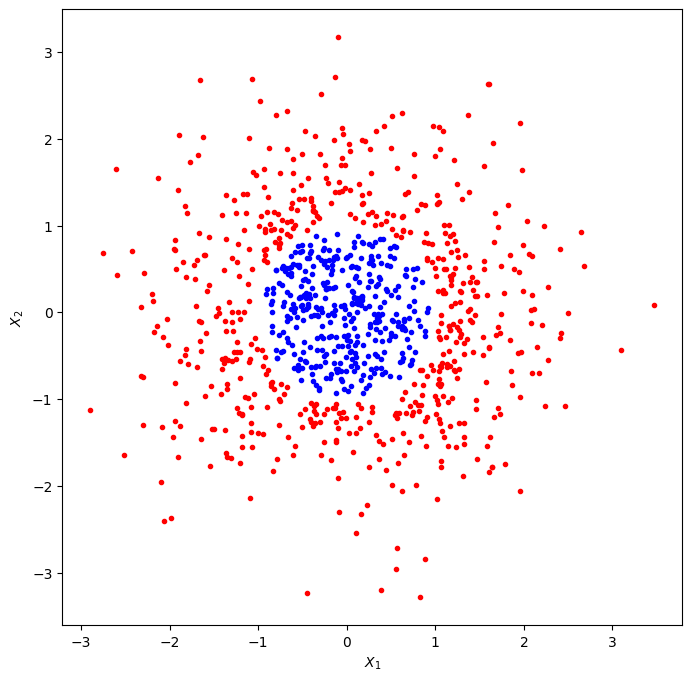

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(*xc1, '.b')
plt.plot(*xc2, '.r')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

**Preguntas**
* ¿Podemos trazar una recta que separe ambas clases?
* ¿Podemos trazar una **curva** que lo haga?
* ¿Dirían que este conjunto es _linealmente separable_?

El mismo conjunto puede representarse usando otras coordenadas (*features*), las coordenadas polares, donde cada punto está identificado por su distancia al origen (_radio_) y por su ángulo con respecto a la dirección positiva del eje $x$ (_ángulo polar_)

Veamos a este dataset en esas coordenadas.

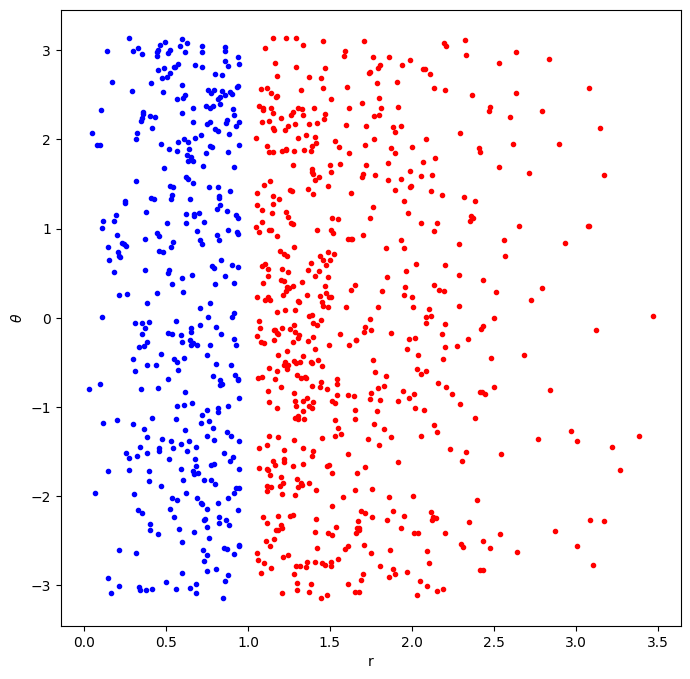

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(phi1[0], phi1[1], '.b')
plt.plot(phi2[0], phi2[1], '.r')
plt.xlabel('r')
plt.ylabel(r'$\theta$')
plt.show()

* ¿Cambiarían las respuestas a las preguntas de arriba? ¡Este es _el mismo_ conjunto de datos!

Ahora veamos cómo le va al perceptron con este dataset.

[[ 1.30000000e+01]
 [-1.31577970e+01]
 [ 9.76513167e-03]]


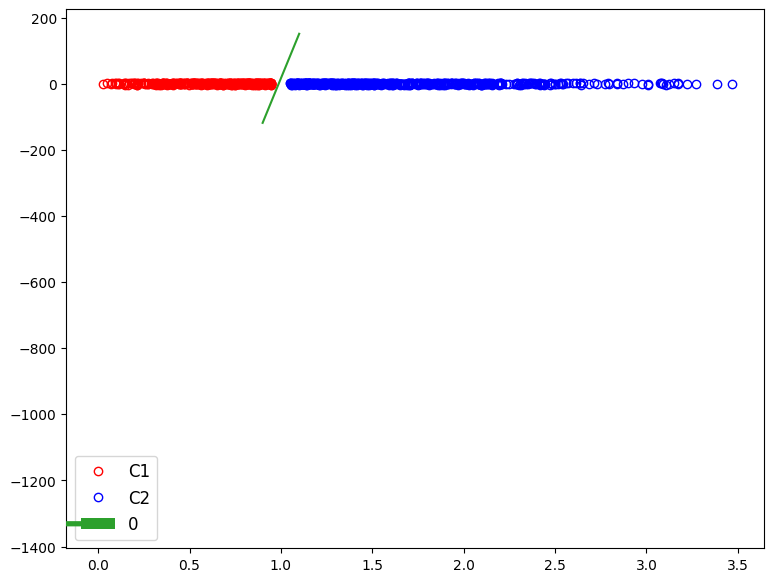

In [25]:
t = np.concatenate([t1, t2]) #vector de etiquetas que contiene todas las etiquetas
x = np.vstack([phi1.T, phi2.T]) #la matriz de datos en coordenadas polares, tiene dos columnas: una para el radio y otra para el ángulo de cada punto.

perce = Perceptron(max_iter=1000, tol=1e-10, random_state=2020202) #núm máx de iteraciones=1000 y una tolerancia de convergencia (tol=1e-10).

# Ajusto
perce.fit(x, t)
w = makew(perce) #extrae el vector de parámetros w del modelo ajustado perce, incluye el intercepto y los pesos.
# w se usará para trazar el límite de decisión en el gráfico.
print(w)
plot_clasi(x, t, [w,], xp=[0.9, 1.1],  spines=None, equal=False)
#[w,]: el vector de parámetros del perceptrón, que se usa para calcular y trazar el límite de decisión.
#xp=[0.9, 1.1]: los límites de las coordenadas x que se utilizarán para el trazado de la línea de decisión.

Y volvemos al espacio original

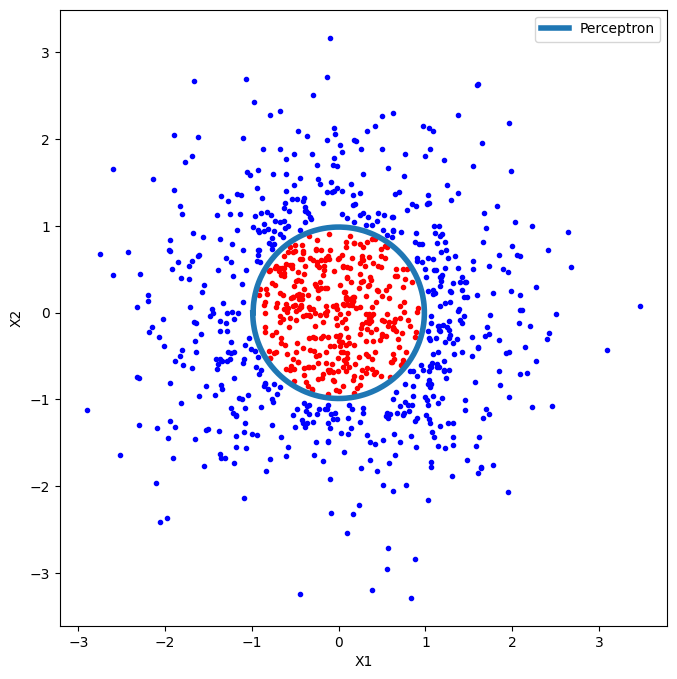

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.plot(*xc1, '.r')
plt.plot(*xc2, '.b')
plt.gca().set_aspect('equal') #asegura que los ejes X1 y X2 tengan la misma escala para visualizar correctamente los círculos.
plt.xlabel('X1')
plt.ylabel('X2')

# Puntos en el planno
yp = x[:, 1]
xp = (w[0] - w[2]*yp)/w[1]

# Convertir de nuevo al espacio de entrada original, manteniendo el signo
signx1 = np.where((yp > -np.pi/2) * (yp <= np.pi/2), 1, -1)
signx2 = np.where((yp > 0) * (yp <= np.pi), 1, -1)

x1p = signx1 * np.sqrt(xp**2/(1 + np.tan(yp)**2))
x2p = signx2 * np.sqrt(xp**2 - x1p**2)

# Graficamos
i = np.argsort(yp)
plt.plot(x1p[i], x2p[i], '-', lw=4, label='Perceptron')

plt.legend()
plt.show()

**Conclusión**. Si logramos encontrar el cambio de coordenadas adecuado, algunos problemas pueden *volverse* linealmente separables.

# Ejercicio: MNIST

Para mostrar que no solo se pueden clasificar puntos en dos dimensiones, en esta sección, van a usar el perceptrón para clasificar los datos de MNIST, este clásico dataset contiene unas 70000 imágenes de 28x28 píxeles de dígitos escritos a mano en escala de grises, cada uno etiquetado con su valor correspondiente (de 0 a 9).

Como el perceptrón solo funciona para clasificaciones binarias, vamos a transformarlo artificialmente para clasificar las imágenes de los dígitos en 5 y no-5.

## Datos

Bajamos los datos usando directamente `sklearn`. Según la versión, esto cambia un poco:


In [27]:
#librerías necesarias para realizar este ejercicio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]/255.0 # vean la normalización
t = mnist["target"]

In [28]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

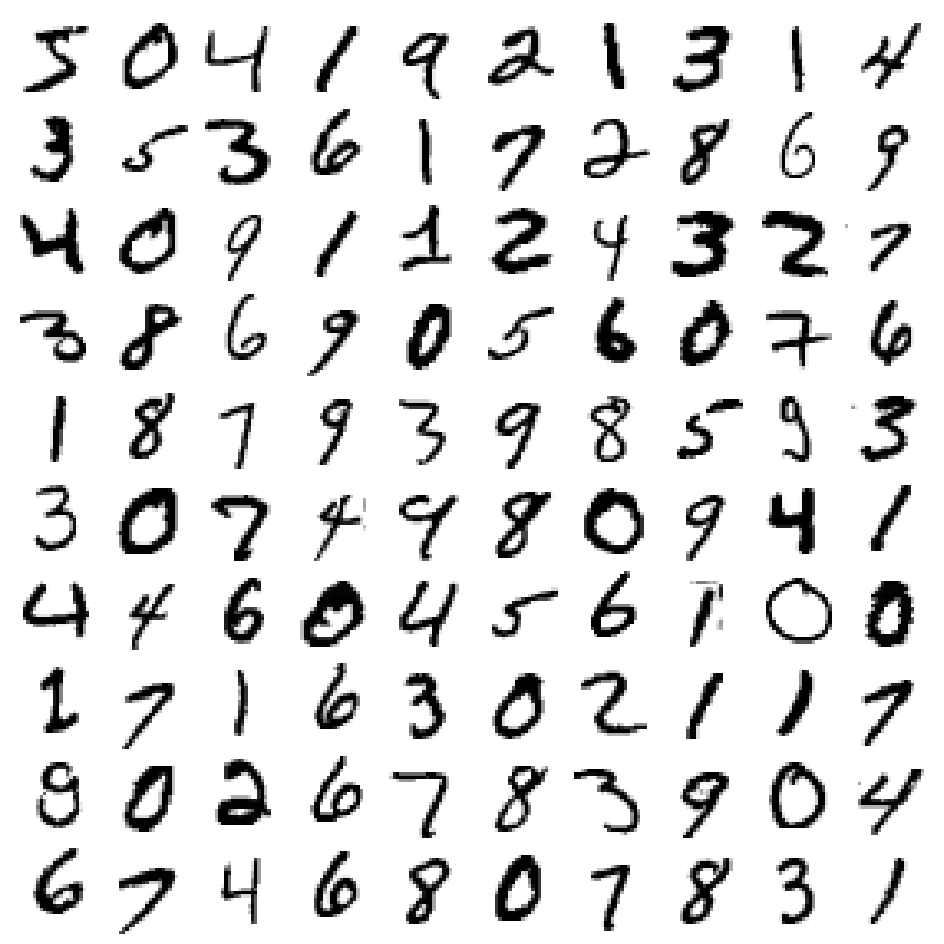

In [29]:
# veamoslas graficamente

fig =  plt.figure(figsize=(12,12))
plot_digits(X[:100], 10)

Para separar en *conjunto de entrenamiento* y de *test* usamos el hecho de que MNIST ya tiene una separación hecha que asegura el correcto equilibrio de cada clase en cada conjunto.

In [30]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]

Y finalmente, barajamos los datos para asegurar que tenemos una buena distribución de las clases para hacer CV.

In [31]:
shuffle_index = np.random.permutation(60000)
X_train, t_train = X_train[shuffle_index], t_train[shuffle_index]

Ahora cambiamos los targets de forma artificial para clasificar los datos en 5 y no-5. Solo necesitamos cambiar las etiquestas; los datos tenemos que dejarlos igual.

In [32]:
t_train5 = t_train == 5
t_test5 = t_test == 5

***

## **Tarea**

* Ahora instancien un `Perceptron` y ajusten con los datos que generamos.

* Calculen las métricas que vimos en el notebook.